# Experimenting with XGBoost to Improve Model Performance

## Includes temporal cross-validation

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

from xgboost import XGBClassifier

DATA_PROCESSED = Path("../data/processed/hr_attrition_clean.csv")
df = pd.read_csv(DATA_PROCESSED)

TARGET_COL = "attrited"
DATE_COL_CANDIDATES = ["snapshot_date", "snapshot_dt", "asof_date", "date"]
YEAR_COL_CANDIDATES = ["snapshot_year", "year"]

# Parse a date/year column
date_col = next((c for c in DATE_COL_CANDIDATES if c in df.columns), None)
year_col = next((c for c in YEAR_COL_CANDIDATES if c in df.columns), None)

if year_col is None:
    if date_col is None:
        raise ValueError("No snapshot date/year column found. Add 'snapshot_date' or 'snapshot_year'.")
    df[date_col] = pd.to_datetime(df[date_col])
    df["snapshot_year"] = df[date_col].dt.year
    year_col = "snapshot_year"

years = sorted(df[year_col].unique())
print("Years in data:", years)
assert TARGET_COL in df.columns

Years in data: [np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024)]


In [43]:
drop_cols = [
    "employee_id",
    "exit_interview_scheduled",
    "offboarding_ticket_created",
    "months_since_hire",
    "salary_band",              # keep base_salary as canonical comp measure
    year_col                    # year is for splitting, not a predictor
]

df_model = df

In [44]:
# I want to test whether high workload combined with poor manager performance can strongly influence attrition

# Create a binary flag to show if there's a suspected poor manager and high workload for an employee (for stakeholder insights)
def make_mgmt_workload_risk(df, mq_col="manager_quality", wl_col="workload_score"):
    mq = df[mq_col]
    wl = df[wl_col]

    df["mgmt_workload_risk"] = (
        (mq.isna()) |
        ((mq < 5) & (wl > 7))
    ).astype(int)

    return df

df_model = make_mgmt_workload_risk(df_model)
df_model.head()

,employee_id,snapshot_date,hire_date,region,department,role,level,is_manager,age,gender,...,exit_interview_scheduled,offboarding_ticket_created,attrited,months_since_hire,salary_band,commute_zero,internal_moves_flag,stock_grants_flag,snapshot_year,mgmt_workload_risk
0,121752,2020-05-13,2014-08-10,amer,sales,sales manager,ic3,0,33,f,...,0,0,0,69.1,q4,0,0,0,2020,0
1,107208,2020-09-20,2011-07-14,apac,engineering,swe ii,manager,1,31,f,...,0,0,0,110.2,q5,0,0,1,2020,0
2,117058,2020-12-29,2013-07-28,emea,sales,ae,ic2,0,40,m,...,0,0,0,89.1,q3,0,1,0,2020,0
3,120754,2023-10-31,2012-04-06,amer,engineering,ml engineer,ic4,0,26,m,...,0,0,0,138.8,q4,1,0,1,2023,0
4,122505,2022-07-20,2015-05-25,apac,hr,hrbp,ic3,0,31,f,...,1,0,1,85.8,q3,0,0,0,2022,0


In [45]:
# Create a continuous column for poor manager/high workload risk to assist with model predictive power

def make_mgmt_workload_score(df, mq_col="manager_quality", wl_col="workload_score"):
    mq = df[mq_col]
    wl = df[wl_col]

    scaler = MinMaxScaler()
    df["mgmt_workload_score"] = scaler.fit_transform(
        (10 - mq + wl).to_numpy().reshape(-1, 1)
    )

    return df

df_model = make_mgmt_workload_score(df_model)
df_model.head()

,employee_id,snapshot_date,hire_date,region,department,role,level,is_manager,age,gender,...,offboarding_ticket_created,attrited,months_since_hire,salary_band,commute_zero,internal_moves_flag,stock_grants_flag,snapshot_year,mgmt_workload_risk,mgmt_workload_score
0,121752,2020-05-13,2014-08-10,amer,sales,sales manager,ic3,0,33,f,...,0,0,69.1,q4,0,0,0,2020,0,0.476162
1,107208,2020-09-20,2011-07-14,apac,engineering,swe ii,manager,1,31,f,...,0,0,110.2,q5,0,0,1,2020,0,0.466031
2,117058,2020-12-29,2013-07-28,emea,sales,ae,ic2,0,40,m,...,0,0,89.1,q3,0,1,0,2020,0,0.432062
3,120754,2023-10-31,2012-04-06,amer,engineering,ml engineer,ic4,0,26,m,...,0,0,138.8,q4,1,0,1,2023,0,0.651371
4,122505,2022-07-20,2015-05-25,apac,hr,hrbp,ic3,0,31,f,...,0,1,85.8,q3,0,0,0,2022,0,0.451728


In [46]:
drop_vif_cols = [
    "compa_ratio",
    "avg_raise_3y",
    "benefit_score",
    "manager_quality",         
    "age",
    "internal_moves_last_2y",
    "mgmt_workload_risk",
    "stock_grants"
]

drop_cols = [c for c in (drop_cols + drop_vif_cols) if c in df.columns]
df_model = df_model.drop(columns=drop_cols)

# Split features/target
X_all = df_model.drop(columns=[TARGET_COL])
y_all = df[TARGET_COL].astype(int)

num_cols = X_all.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_all.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
print("Num:", len(num_cols), "Cat:", len(cat_cols))

Num: 20 Cat: 7


In [47]:
X_all.columns

Index(['snapshot_date', 'hire_date', 'region', 'department', 'role', 'level',
       'is_manager', 'gender', 'remote_status', 'commute_km', 'tenure_years',
       'base_salary', 'time_since_last_promo_yrs', 'performance_rating',
       'engagement_score', 'workload_score', 'learning_hours_last_yr',
       'overtime_hours_month', 'night_shift', 'schedule_flex', 'sick_days',
       'pto_days_taken', 'leave_last_yr', 'team_id', 'commute_zero',
       'internal_moves_flag', 'stock_grants_flag', 'mgmt_workload_score'],
      dtype='object')

In [48]:
# Preprocessor
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=False))  # safe for sparse downstream
])
categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

# Use XGBClassifier inside SelectFromModel to pick informative transformed features
selector = SelectFromModel(
    XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.08,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="hist",      
        random_state=42,
        n_jobs=-1
    ),
    threshold="median",
    prefit=False
)

# Baseline Logistic Regression
pipe_lr = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("select", selector),
    ("clf", LogisticRegression(max_iter=1000))
])

# Main XGBoost model (no early stopping inside pipeline for simplicity)
pipe_xgb = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("select", selector),
    ("clf", XGBClassifier(
        n_estimators=600,
        max_depth=5,
        learning_rate=0.06,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.5,
        min_child_weight=1.0,
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="hist",     
        random_state=42,
        n_jobs=-1
    ))
])

models = {"LogReg+SelectFromModel": pipe_lr, "XGB+SelectFromModel": pipe_xgb}

In [49]:
def eval_temporal_split(model, X, y, years_series, train_max_year, verbose=True):
    test_year = train_max_year + 1
    tr_mask = years_series <= train_max_year
    te_mask = years_series == test_year
    if te_mask.sum() == 0:
        raise ValueError(f"No rows for test year {test_year}.")

    X_tr, y_tr = X.loc[tr_mask], y.loc[tr_mask]
    X_te, y_te = X.loc[te_mask], y.loc[te_mask]

    model.fit(X_tr, y_tr)
    proba = model.predict_proba(X_te)[:, 1]
    pred  = (proba >= 0.5).astype(int)

    auc = roc_auc_score(y_te, proba)
    ap  = average_precision_score(y_te, proba)
    if verbose:
        print(f"Train ≤ {train_max_year} → Test {test_year} | AUC={auc:.3f} | PR AUC={ap:.3f}")
        print(classification_report(y_te, pred, digits=3))

    fpr, tpr, _ = roc_curve(y_te, proba)
    prec, rec, _ = precision_recall_curve(y_te, proba)
    return {"auc": auc, "ap": ap, "fpr": fpr, "tpr": tpr, "prec": prec, "rec": rec, "model": model, "train_year": train_max_year, "test_year": test_year}

In [50]:
target_train_year = 2022
assert target_train_year in years and (target_train_year + 1) in years, "Need 2022 & 2023 in data."

res = {}
for name, mdl in models.items():
    res[name] = eval_temporal_split(mdl, X_all, y_all, df[year_col], target_train_year, verbose=True)

Train ≤ 2022 → Test 2023 | AUC=0.646 | PR AUC=0.268
              precision    recall  f1-score   support

           0      0.831     0.985     0.902      4204
           1      0.396     0.045     0.081       882

    accuracy                          0.822      5086
   macro avg      0.614     0.515     0.492      5086
weighted avg      0.756     0.822     0.759      5086

Train ≤ 2022 → Test 2023 | AUC=0.639 | PR AUC=0.267
              precision    recall  f1-score   support

           0      0.832     0.985     0.902      4204
           1      0.415     0.050     0.089       882

    accuracy                          0.823      5086
   macro avg      0.623     0.518     0.496      5086
weighted avg      0.759     0.823     0.761      5086



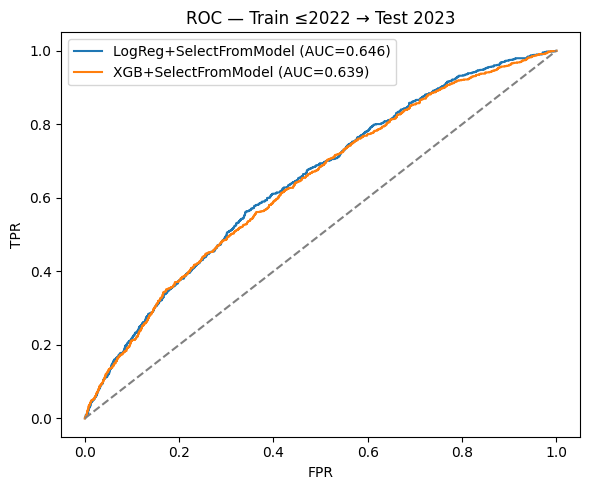

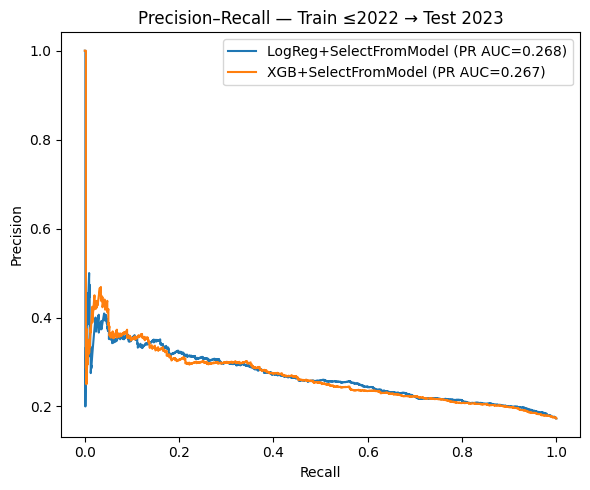

In [51]:
plt.figure(figsize=(6,5))
for name, r in res.items():
    plt.plot(r["fpr"], r["tpr"], label=f"{name} (AUC={r['auc']:.3f})")
plt.plot([0,1],[0,1],"--",color="gray")
plt.title(f"ROC — Train ≤{target_train_year} → Test {target_train_year+1}")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.tight_layout()
plt.savefig("../reports/ROCcomparisonXGBoost.png")
plt.show()

plt.figure(figsize=(6,5))
for name, r in res.items():
    plt.plot(r["rec"], r["prec"], label=f"{name} (PR AUC={r['ap']:.3f})")
plt.title(f"Precision–Recall — Train ≤{target_train_year} → Test {target_train_year+1}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend(); plt.tight_layout()
plt.savefig("../reports/Precision-RecallXGBoost.png")
plt.show()

In [52]:
def rolling_backtest(models, X, y, years_series, min_train_year=None):
    years_sorted = sorted(years_series.unique())
    if min_train_year is None:
        min_train_year = years_sorted[0] + 1
    summary = {name: [] for name in models}
    for y_train_max in years_sorted:
        y_test = y_train_max + 1
        if y_train_max < min_train_year or y_test not in years_sorted:
            continue
        for name, mdl in models.items():
            r = eval_temporal_split(mdl, X, y, years_series, y_train_max, verbose=False)
            summary[name].append((y_train_max, r["auc"], r["ap"]))
    return summary

bt = rolling_backtest(models, X_all, y_all, df[year_col])
for name, rows in bt.items():
    if rows:
        years_, aucs, aps = zip(*rows)
        print(name, "AUC:", np.round(np.mean(aucs),3), "±", np.round(np.std(aucs),3),
              "| PR AUC:", np.round(np.mean(aps),3), "±", np.round(np.std(aps),3))

LogReg+SelectFromModel AUC: 0.65 ± 0.006 | PR AUC: 0.264 ± 0.005
XGB+SelectFromModel AUC: 0.644 ± 0.011 | PR AUC: 0.274 ± 0.012


In [53]:
from joblib import dump
best_name = max(res.keys(), key=lambda n: res[n]["auc"])
best_pipe = models[best_name]
print("Selected:", best_name)

# Refit on all data ≤ 2022, then save
train_mask_final = df[year_col] <= target_train_year
best_pipe.fit(X_all.loc[train_mask_final], y_all.loc[train_mask_final])

Path("../models").mkdir(parents=True, exist_ok=True)
dump(best_pipe, f"../models/attrition_model_timesplit_xgb_train_to_{target_train_year}.pkl")
print("Saved:", f"../models/attrition_model_timesplit_xgb_train_to_{target_train_year}.pkl")

Selected: LogReg+SelectFromModel
Saved: ../models/attrition_model_timesplit_xgb_train_to_2022.pkl
